## Prediction of payment of premium on time by customers of an Insurance Company

#### Importing essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train_df = pd.read_csv("train_qnU1GcL.csv")
test_df = pd.read_csv("test_LxCaReE_DvdCKVT2_7rMflxW_P2f9VpT.csv")

In [3]:
train_df.describe(include='all')

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,target
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853,79853,79853.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,Urban,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43134,48183,NaN
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,NaN,NaN,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,NaN,NaN,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,NaN,NaN,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,NaN,NaN,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,NaN,NaN,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,NaN,NaN,1.000000


### Nearly 94% of the target variable is 1, which means that for 94% of the observation the premium is paid on time. This suggest that the dataset is biased. Have to keep an eye during model training.
#### Sourcing channel of the application has 5 different values out of which 'A' is the most frequent one. Also most customers are from Urban residential area.
#### The age variable is in days, it has to be converted to years for smoother understanding.

#### Identification of variables

In [4]:
variables = pd.DataFrame(columns=['Name', 'Type', 'Data Type'])
variables['Name'] = train_df.columns
variables['Data Type'] = list(train_df.dtypes)
variables = variables.assign(Type = np.where(variables.Name == 'target', 'Target', 'Predictor'))
variables.loc[variables['Name']=='id', 'Type'] = 'None'
variables

,Name,Type,Data Type
0,id,None,int64
1,perc_premium_paid_by_cash_credit,Predictor,float64
2,age_in_days,Predictor,int64
3,Income,Predictor,int64
4,Count_3-6_months_late,Predictor,float64
5,Count_6-12_months_late,Predictor,float64
6,Count_more_than_12_months_late,Predictor,float64
7,application_underwriting_score,Predictor,float64
8,no_of_premiums_paid,Predictor,int64
9,sourcing_channel,Predictor,object


#### Let's go through each variable

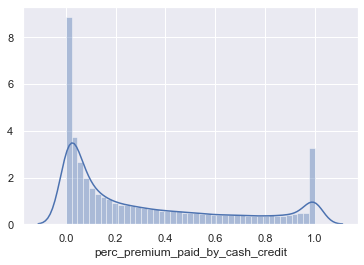

In [5]:
# this is the percentage amount of premium paid in cash or credit
## the distribution is spread out and not consistent
sns.distplot(train_df['perc_premium_paid_by_cash_credit'])

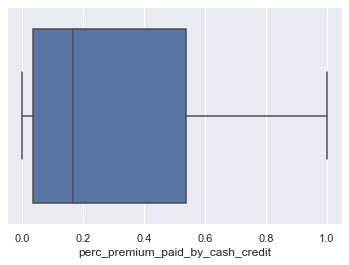

In [6]:
sns.boxplot(x='perc_premium_paid_by_cash_credit', data=train_df)

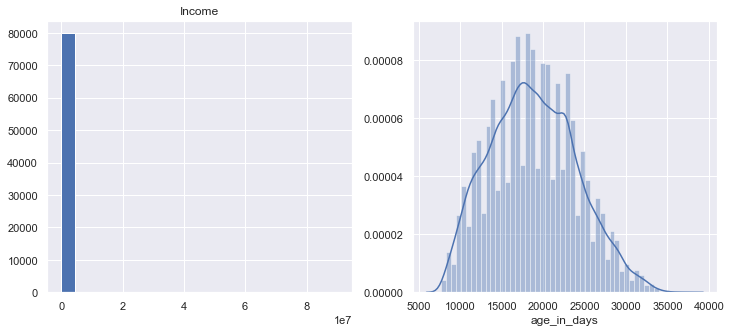

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_df['Income'].hist(bins=20, ax=ax1)
ax1.set_title('Income')
ax2 = sns.distplot(train_df['age_in_days'])

#### Income as well as age variable needs to be transformed later to get better distribution

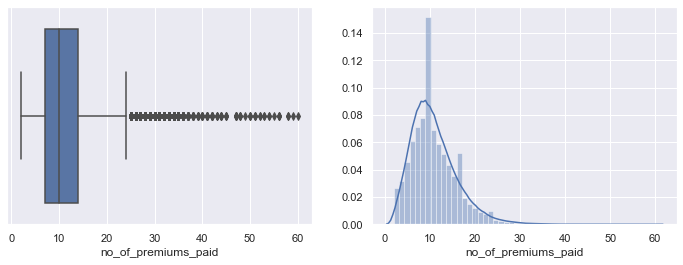

In [8]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='no_of_premiums_paid', data=train_df, ax=axes[0])
sns.distplot(train_df['no_of_premiums_paid'], ax=axes[1])

##### As can be seen from the boxplot, there are some extreme values present in no of premiums paid. It can't be called outliers as people with higher income or stable jobs will try to pay the premium within time.
##### Now these premiums are different from the late premiums in the three columns [3-6months late, 6-12months late, 12+months late] as these are the premiums paid on time.

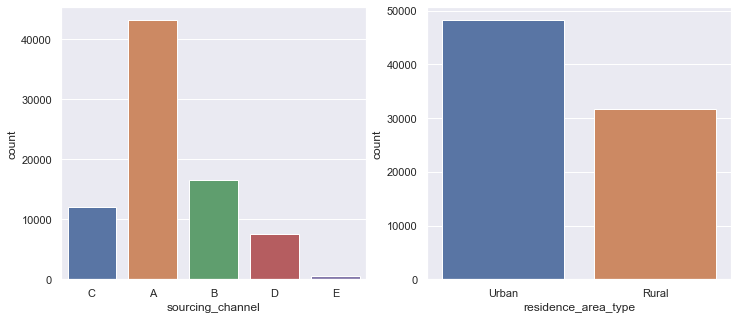

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='sourcing_channel', data=train_df, ax=ax1)
sns.countplot(x='residence_area_type', data=train_df, ax=ax2)

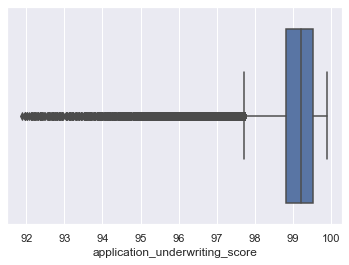

In [10]:
sns.boxplot(x=train_df['application_underwriting_score'])

##### There are quite a few lower values than (1.5*IQR) which are natural outlier.

### Let's look at the correlation between the numerical variables

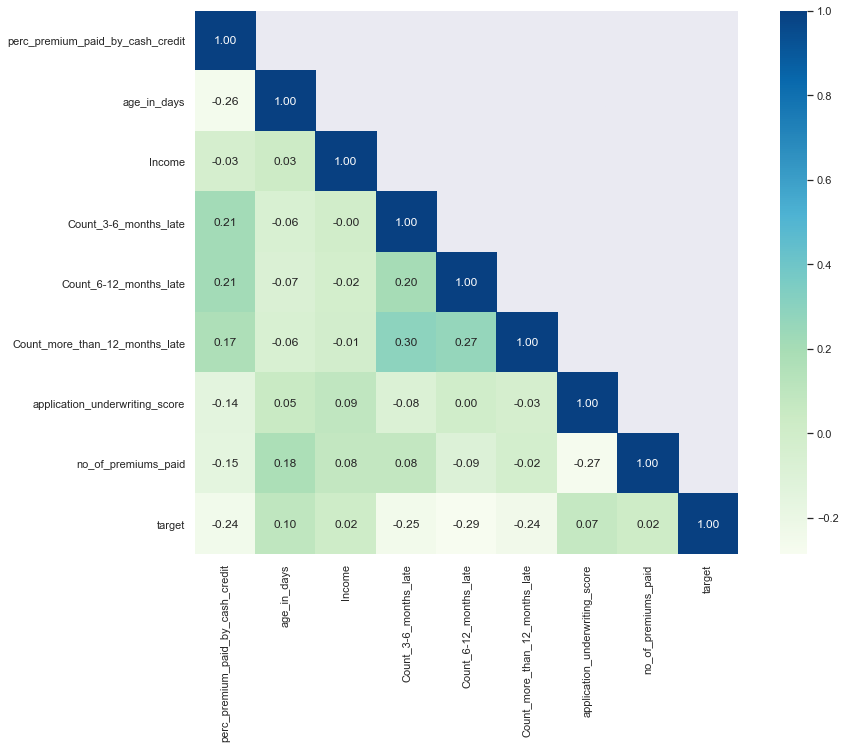

In [11]:
corr = train_df.drop(['id'], axis=1).corr(method='pearson')
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='GnBu', fmt='.2f')

Inferences that could be drawn are:

1. The correlation between the variables are not much prominent. It maybe due to the fact that the dataset is highly imbalanced and biased towards one class.
2. It does seem that there is little correlation between late premium and target. As well as with percentage premium amount paid.
3. The three late premium columns seems to have some colinearity between them, that will be dealt with during feature transformation and creation.

Let's check some more multivariate analysis.

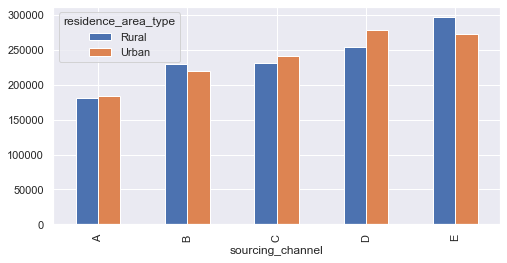

In [12]:
train_df.pivot_table(values='Income', index='sourcing_channel', columns='residence_area_type').plot(kind='bar', figsize=(8, 4))

##### sourcing channel A has the highest count of all so the mean income in that group is sigficantly lower as most observation of any level of income are there.

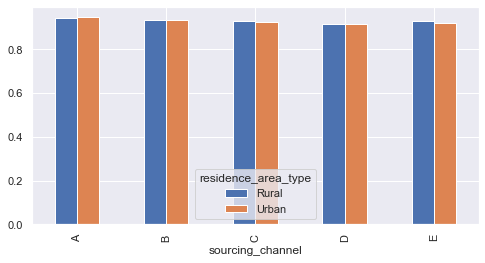

In [13]:
train_df.pivot_table(values='target', index='sourcing_channel', columns='residence_area_type').plot(kind='bar', figsize=(8, 4))

#### The mean target is the same for all the categorical features, which suggest same rate of successful permium payment

In [14]:
pd.cut(train_df['perc_premium_paid_by_cash_credit'], bins=5).value_counts()

(-0.001, 0.2]    42568
(0.8, 1.0]       11801
(0.2, 0.4]       11530
(0.4, 0.6]        7914
(0.6, 0.8]        6040
Name: perc_premium_paid_by_cash_credit, dtype: int64

In [15]:
for df in [train_df, test_df]:
    df['perc_paid_bins'] = pd.cut(train_df['perc_premium_paid_by_cash_credit'], bins=5, labels=False)

#### Check for missing values

In [16]:
train_df.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
target                                 0
perc_paid_bins                         0
dtype: int64

There are null values in late premium payment columns, and the colmns are somewhat correlated with perc premium paid in cash or credit. Missing values can be dealt with after some feature creation and transformation

In [17]:
# creating a single column for late payment of premium from the three late payment columns
for df in [train_df, test_df]:
    df['total_no_of_late_premium_payment'] = df['Count_more_than_12_months_late'] + df['Count_3-6_months_late'] + df['Count_6-12_months_late']
    df.drop(['Count_more_than_12_months_late', 'Count_3-6_months_late', 'Count_6-12_months_late'], axis=1, inplace=True)

In [18]:
train_df[['total_no_of_late_premium_payment', 'target']].corr()

,total_no_of_late_premium_payment,target
total_no_of_late_premium_payment,1.000000,-0.356396
target,-0.356396,1.000000


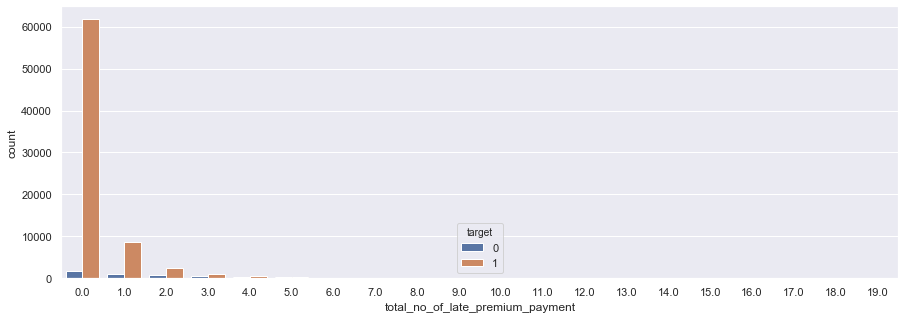

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(x='total_no_of_late_premium_payment', hue='target', data=train_df)

In [20]:
train_df[['total_no_of_late_premium_payment', 'target']].groupby(['total_no_of_late_premium_payment']).mean()

,target
total_no_of_late_premium_payment,
0.0,0.971659
1.0,0.890487
2.0,0.780694
3.0,0.695418
4.0,0.579800
5.0,0.510684
6.0,0.441696
7.0,0.487654
8.0,0.455556


#### So after 5 late payments, premium is never paid

In [21]:
train_df.loc[(train_df['target'] == 0) & (train_df['total_no_of_late_premium_payment'].isnull()), 'total_no_of_late_premium_payment'] = 5
train_df.loc[(train_df['target'] == 1) & (train_df['total_no_of_late_premium_payment'].isnull()), 'total_no_of_late_premium_payment'] = 0

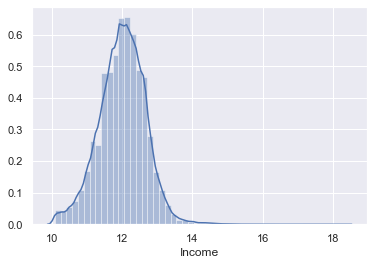

In [22]:
## Transforming the Income variable by taking log gives better distribution
sns.distplot(np.log(train_df['Income']))

In [23]:
# Transformation of the Income. Since it has exponential distribution, transforming it by taking log of it.
for df in [train_df, test_df]:
    df['log_income'] = np.log(df['Income'])
    df['Income_bands'] = pd.qcut(train_df['Income'], 4, precision=0, labels=False)

In [24]:
pd.qcut(train_df['Income'], 4, precision=0).value_counts()

(166560.0, 252090.0]      19971
(108010.0, 166560.0]      19966
(24029.0, 108010.0]       19964
(252090.0, 90262600.0]    19952
Name: Income, dtype: int64

#### The outliers are replaced with 99th quartiles as it can represent the distribution much better
#### And also deals with outlier bias in the data. Income being higher than 99th percentile doesn't have much effect on premium prediction


In [25]:
print(train_df['log_income'].quantile(0.99), test_df['log_income'].quantile(0.99))
print(train_df['log_income'].quantile(0.01), test_df['log_income'].quantile(0.01))

13.555544812644555 13.527935146490675
10.312280450736967 10.313276632124348


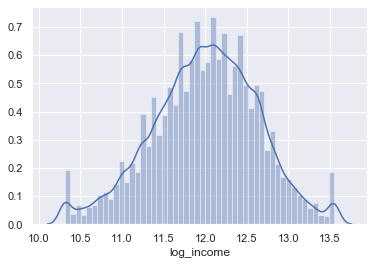

In [26]:
train_df.loc[train_df['log_income'] > train_df['log_income'].quantile(0.99), 'log_income'] = 13.555544812644555
train_df.loc[train_df['log_income'] < train_df['log_income'].quantile(0.01), 'log_income'] = 10.312280450736967
sns.distplot(train_df['log_income'])

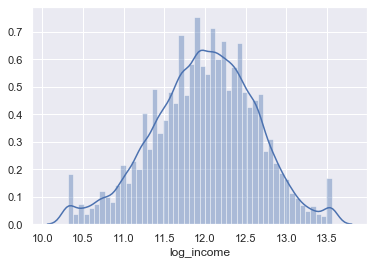

In [27]:
test_df.loc[test_df['log_income'] > test_df['log_income'].quantile(0.99), 'log_income'] = 13.555544812644555
test_df.loc[test_df['log_income'] < test_df['log_income'].quantile(0.01), 'log_income'] = 10.312280450736967
sns.distplot(test_df['log_income'])

##### Looking at the age variable. It can be converted to age in years from age in days.

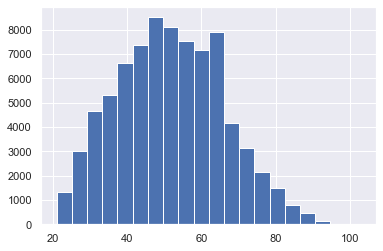

In [28]:
for df in [train_df, test_df]:
    df['age'] = (df['age_in_days']//365)
    df.drop(['age_in_days'], axis=1, inplace=True)
    
train_df['age'].hist(bins=20)

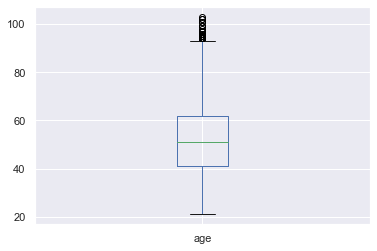

In [29]:
train_df['age'].plot(kind='box')

Age has some values acting as outlier as seen from the boxplot.

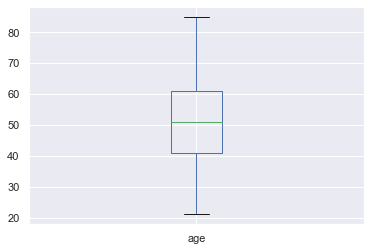

In [30]:
(train_df[train_df['age'] < train_df['age'].quantile(0.99)]['age']).plot(kind='box')

In [31]:
print(train_df['age'].quantile(0.99), test_df['age'].quantile(0.99))

86.0 86.0


#### The age variable has few extreme values above 99th quartile. Since the age of 86 and above that would be having the same effect on the premium prediction, the values above the 99th percentile can be replaced with the 99th percentile itself

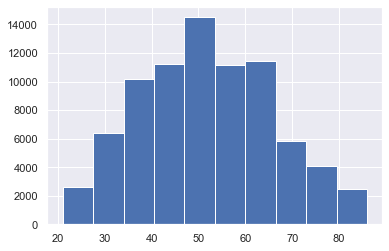

In [32]:
for dataset in [train_df, test_df]:
    dataset.loc[dataset['age'] > dataset['age'].quantile(0.99), 'age'] = 86
    
train_df['age'].hist()

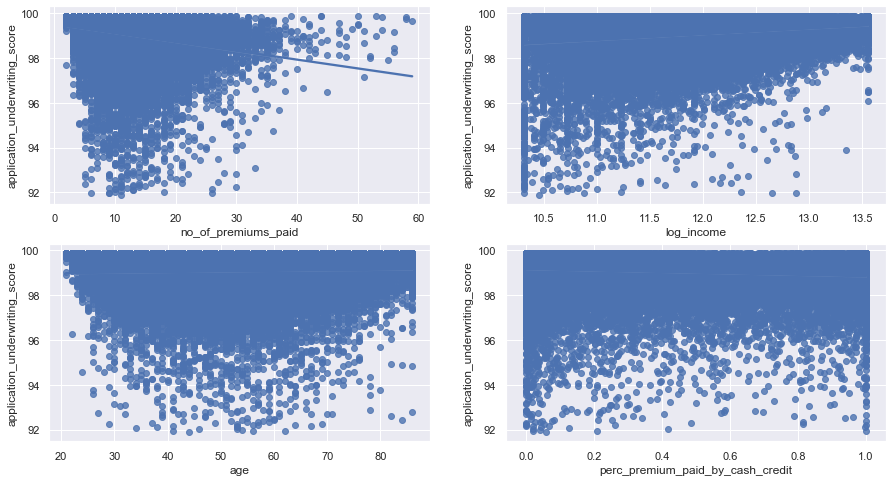

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
sns.regplot(x='no_of_premiums_paid', y='application_underwriting_score', data=train_df, ax=ax1)
sns.regplot(x='log_income', y='application_underwriting_score', data=train_df, ax=ax2)
sns.regplot(x='age', y='application_underwriting_score', data=train_df, ax=ax3)
sns.regplot(x='perc_premium_paid_by_cash_credit', y='application_underwriting_score', data=train_df, ax=ax4)

#### Application Underwriting Score doesn't seem to have much strong relation with any of the numeric variables in the dataset. Although number of premium paid and income could be used to predict the same as some little relation exist. 

In [34]:
from sklearn.linear_model import LinearRegression
l_reg = LinearRegression()

In [35]:
for df in [train_df, test_df]:
    l_reg.fit(df.dropna(subset=['application_underwriting_score'])[['no_of_premiums_paid', 'log_income']], df.dropna(subset=['application_underwriting_score'])['application_underwriting_score'])
    for i, row in enumerate(df['application_underwriting_score'].isnull()):
        if row==True:
            no_of_premiums_paid = df.loc[i, 'no_of_premiums_paid']
            log_income = df.loc[i, 'log_income']
            df.loc[i, 'application_underwriting_score'] = l_reg.predict([[no_of_premiums_paid, log_income]])

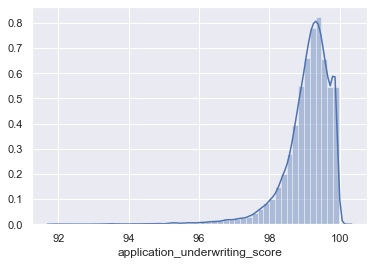

In [36]:
sns.distplot(test_df['application_underwriting_score'])

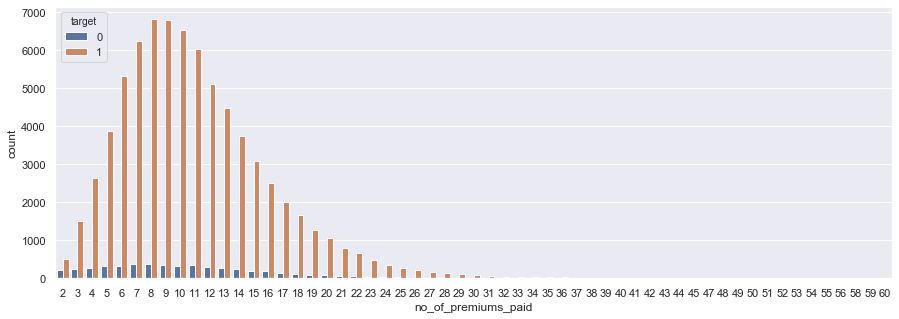

In [37]:
plt.figure(figsize=(15, 5))
sns.countplot(x='no_of_premiums_paid', hue='target', data=train_df)

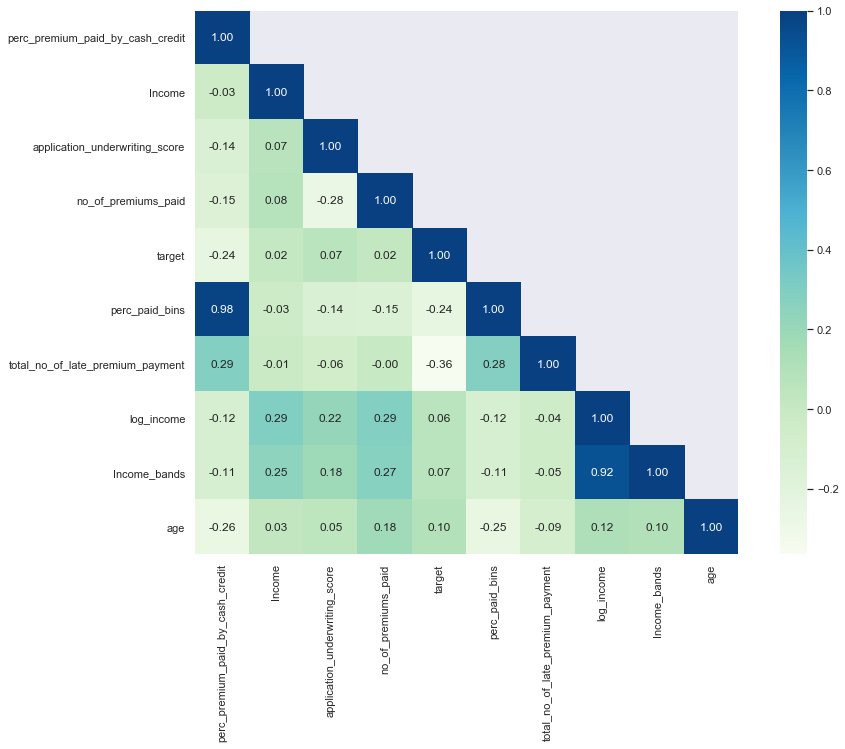

In [38]:
corr = train_df.drop(['id'], axis=1).corr(method='pearson')
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='GnBu', fmt='.2f')

In [39]:
table = test_df.pivot_table(values='total_no_of_late_premium_payment', index='sourcing_channel', columns='residence_area_type', aggfunc=lambda x: np.round(x.mean()))

test_df['total_no_of_late_premium_payment'].fillna(test_df[test_df['total_no_of_late_premium_payment'].isnull()].apply(lambda x: table.loc[x['sourcing_channel'], x['residence_area_type']], axis=1), inplace=True)
test_df.isnull().sum()

id                                  0
perc_premium_paid_by_cash_credit    0
Income                              0
application_underwriting_score      0
no_of_premiums_paid                 0
sourcing_channel                    0
residence_area_type                 0
perc_paid_bins                      0
total_no_of_late_premium_payment    0
log_income                          0
Income_bands                        0
age                                 0
dtype: int64

In [40]:
train_df.dtypes

id                                    int64
perc_premium_paid_by_cash_credit    float64
Income                                int64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
target                                int64
perc_paid_bins                        int64
total_no_of_late_premium_payment    float64
log_income                          float64
Income_bands                          int64
age                                   int64
dtype: object

In [41]:
## Mapping categorical variables to numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for df in [train_df, test_df]:
    # scaling application_underwriting_score
    df['application_underwriting_score'] = df['application_underwriting_score']/100
    # changing datatypes
    df['total_no_of_late_premium_payment'] = df['total_no_of_late_premium_payment'].astype('int64')

In [42]:
# assigning dummy variables in place of categorical variables
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

In [43]:
# pd.cut(train_df.loc[train_df['no_of_premiums_paid'] < train_df['no_of_premiums_paid'].quantile(0.99), 'no_of_premiums_paid'], 5).value_counts()
bins = [0, 5, 10, 15, 20, 60]
pd.cut(train_df['no_of_premiums_paid'], bins=bins, precision=0).value_counts()

(5, 10]     33473
(10, 15]    23806
(0, 5]       9594
(15, 20]     9114
(20, 60]     3866
Name: no_of_premiums_paid, dtype: int64

##### Binning no of premiums paid as it can mess up due to extreme values.

In [44]:
for df in [train_df, test_df]:
    df.loc[df['no_of_premiums_paid'] <= 5, 'no_of_premiums_paid_bins'] = 0
    df.loc[(df['no_of_premiums_paid'] > 5) & (df['no_of_premiums_paid'] <= 10), 'no_of_premiums_paid_bins'] = 1
    df.loc[(df['no_of_premiums_paid'] > 10) & (df['no_of_premiums_paid'] <= 15), 'no_of_premiums_paid_bins'] = 2
    df.loc[(df['no_of_premiums_paid'] > 15) & (df['no_of_premiums_paid'] <= 20), 'no_of_premiums_paid_bins'] = 3
    df.loc[df['no_of_premiums_paid'] > 20, 'no_of_premiums_paid_bins'] = 4

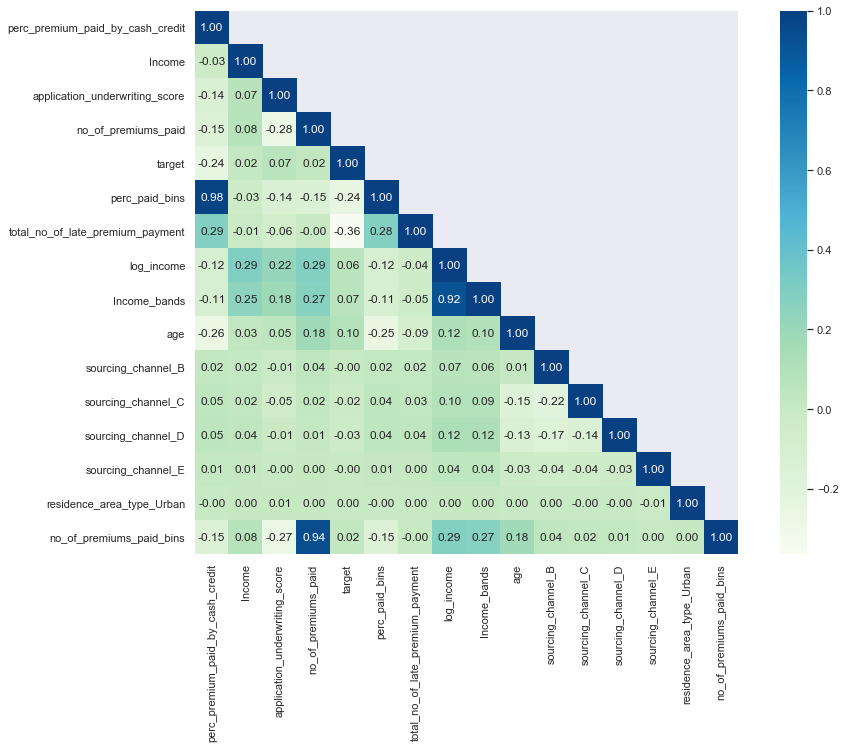

In [45]:
corr = train_df.drop(['id'], axis=1).corr(method='pearson')
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='GnBu', fmt='.2f')

#### Model Building

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

In [70]:
min_max_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()

X = train_df.drop(['target', 'id', 'Income', 'Income_bands', 'perc_paid_bins', 'no_of_premiums_paid'], axis=1)
y = train_df['target']

#### Scaling variables as logistic Regression uses gradient descent based optimization

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=366)

print(x_train.shape, y_train.shape)

(63882, 11) (63882,)


In [49]:
X.head()

,perc_premium_paid_by_cash_credit,application_underwriting_score,total_no_of_late_premium_payment,log_income,age,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Urban,no_of_premiums_paid_bins
0,0.429,0.9902,0,12.780042,33,0,1,0,0,1,2.0
1,0.010,0.9989,0,12.660804,59,0,0,0,0,1,4.0
2,0.917,0.9869,6,11.340237,48,0,1,0,0,0,1.0
3,0.049,0.9957,0,12.431254,42,0,0,0,0,1,1.0
4,0.052,0.9987,0,12.199451,86,1,0,0,0,1,2.0


In [50]:
min_max_scaler.fit(x_train)
std_scaler.fit(x_train)

x_train_scaled = std_scaler.transform(x_train)
x_test_scaled = std_scaler.transform(x_test)

In [51]:
# Confusion matrix
def confusion_matrix(data,actual_values,model):
    # Prediction of values using the model
    pred_values = model.predict_proba(data)[:, 1]
    # specifying bins
    bins=np.array([0,0.5,1])
    # Creating a histogram, where if values are between 0 and 0.5 they will be considered 0
    # if they are between 0.5 and 1, they will be considered 1
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and accuracy
    return cm, accuracy

In [52]:
# Logistic Regression
log_reg = LogisticRegression(solver='saga')

log_reg.fit(x_train_scaled, y_train)
log_reg.score(x_train_scaled, y_train)

0.938949938949939

In [53]:
roc_auc_score(y_test, log_reg.predict_proba(x_test_scaled)[:, 1])

0.8336322270893637

In [54]:
confusion_matrix(x_test_scaled, y_test, log_reg)

(array([[  127.,   842.],
        [   90., 14912.]]),
 0.941644230167178)

#### Random Forest Classifier could give better results

In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(x_train, y_train)

roc_auc_score(y_test, rfc.predict_proba(x_test)[:, 1])

0.815668849932496

In [56]:
confusion_matrix(x_test, y_test, rfc)

(array([[  119.,   850.],
        [   90., 14912.]]),
 0.9411433222716173)

#### Tuning of Random Forest parameters

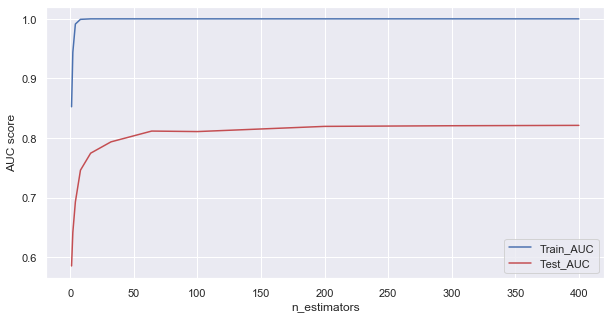

In [57]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400]
train_results = []
test_results = []

for estimator in n_estimators:
    rfc = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rfc.fit(x_train, y_train)
    
    train_pred = rfc.predict_proba(x_train)[:, 1]
    roc_auc = roc_auc_score(y_train, train_pred)
    train_results.append(roc_auc)
    
    test_pred = rfc.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    test_results.append(roc_auc)
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(n_estimators, train_results, 'b', label='Train_AUC')
line2 = plt.plot(n_estimators, test_results, 'r', label='Test_AUC')

plt.legend()

plt.xlabel('n_estimators')
plt.ylabel('AUC score')
plt.show()

#### After 200 n_estimators the score is somewhat constant and doesn't deviates much

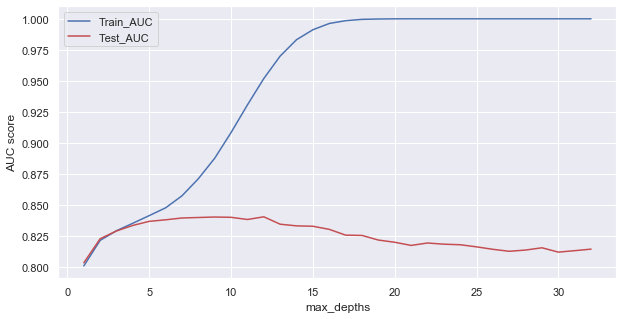

In [58]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

for depth in max_depths:
    rfc = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    rfc.fit(x_train, y_train)
    
    train_pred = rfc.predict_proba(x_train)[:, 1]
    roc_auc = roc_auc_score(y_train, train_pred)
    train_results.append(roc_auc)
    
    test_pred = rfc.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    test_results.append(roc_auc)
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(max_depths, train_results, 'b', label='Train_AUC')
line2 = plt.plot(max_depths, test_results, 'r', label='Test_AUC')

plt.legend()

plt.xlabel('max_depths')
plt.ylabel('AUC score')
plt.show()

#### At the depth of 7 the test results are at the maximum after which it drops. And for the train results overfitting can be seen from the graph

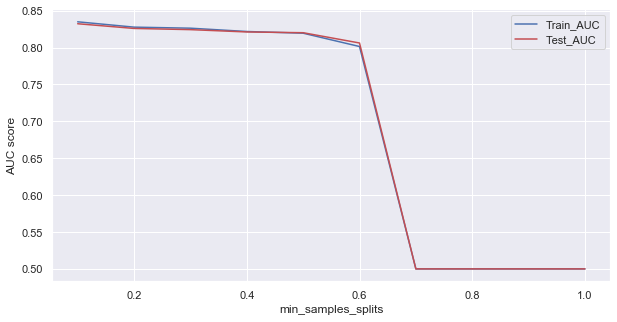

In [59]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []

for split in min_samples_splits:
    rfc = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    rfc.fit(x_train, y_train)
    
    train_pred = rfc.predict_proba(x_train)[:, 1]
    roc_auc = roc_auc_score(y_train, train_pred)
    train_results.append(roc_auc)
    
    test_pred = rfc.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    test_results.append(roc_auc)
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(min_samples_splits, train_results, 'b', label='Train_AUC')
line2 = plt.plot(min_samples_splits, test_results, 'r', label='Test_AUC')

plt.legend()

plt.xlabel('min_samples_splits')
plt.ylabel('AUC score')
plt.show()

#### It is evident that when we require all the sample at each node, the model cannot learn enough about the data. This looks like a underfitting case

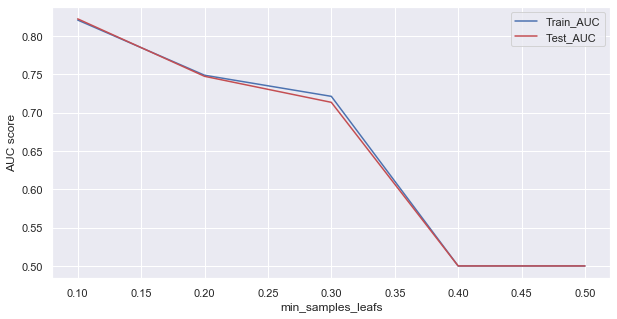

In [60]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

for leafs in min_samples_leafs:
    rfc = RandomForestClassifier(min_samples_leaf=leafs, n_jobs=-1)
    rfc.fit(x_train, y_train)
    
    train_pred = rfc.predict_proba(x_train)[:, 1]
    roc_auc = roc_auc_score(y_train, train_pred)
    train_results.append(roc_auc)
    
    test_pred = rfc.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    test_results.append(roc_auc)
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(min_samples_leafs, train_results, 'b', label='Train_AUC')
line2 = plt.plot(min_samples_leafs, test_results, 'r', label='Test_AUC')

plt.legend()

plt.xlabel('min_samples_leafs')
plt.ylabel('AUC score')
plt.show()

#### Same conclusion as above. Increasing number of samples in leaf causes underfitting.

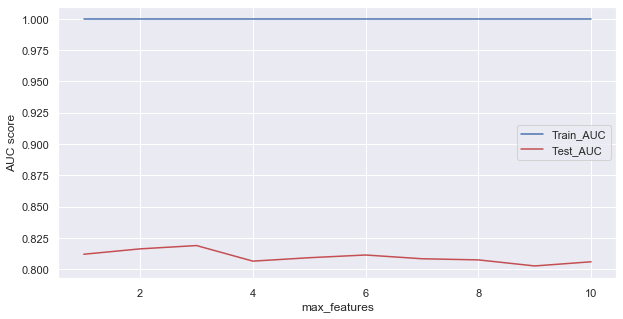

In [61]:
max_features = list(range(1, X.shape[1]))

train_results = []
test_results = []

for features in max_features:
    rfc = RandomForestClassifier(max_features=features, n_jobs=-1)
    rfc.fit(x_train, y_train)
    
    train_pred = rfc.predict_proba(x_train)[:, 1]
    roc_auc = roc_auc_score(y_train, train_pred)
    train_results.append(roc_auc)
    
    test_pred = rfc.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, test_pred)
    test_results.append(roc_auc)
    
plt.figure(figsize=(10, 5))
line1 = plt.plot(max_features, train_results, 'b', label='Train_AUC')
line2 = plt.plot(max_features, test_results, 'r', label='Test_AUC')

plt.legend()

plt.xlabel('max_features')
plt.ylabel('AUC score')
plt.show()

#### Another overfitting case.

### GridSearch for best parameters

In [62]:
rfc = RandomForestClassifier(n_jobs=-1)

param_grid_rfc = {'n_estimators': [200],
                 'max_depth': [6, 7, 8, 9],
                 'min_samples_split': np.linspace(0.01, 0.05, 5, endpoint=True),
                 'min_samples_leaf': np.linspace(0.01, 0.05, 5, endpoint=True)}

best_clf = GridSearchCV(rfc, param_grid=param_grid_rfc, cv=3, n_jobs=-1, scoring='roc_auc')

best_clf.fit(x_train, y_train)

best_clf.score(x_test, y_test)

0.838559674671516

In [72]:
confusion_matrix(x_test, y_test, best_clf)

(array([[    0.,   969.],
        [    0., 15002.]]),
 0.9393275311502097)

#### Even with different parameters there isn't much difference in the score. Since gridsearch scoring pararmeter has roc-auc in it, it is preditcing according to it which in turn is also decreasing the accuaracy or the not predicting the '0' target successfully or at all.

#### As stated above sourcing channel and residence area type does not contribute much, so let's check score dropping those two

In [77]:
X = X[['perc_premium_paid_by_cash_credit', 'application_underwriting_score', 'total_no_of_late_premium_payment', 'log_income', 'age', 'no_of_premiums_paid_bins']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=366)

print(x_train.shape, y_train.shape)

(63882, 6) (63882,)


In [78]:
std_scaler.fit(x_train)

x_train_scaled = std_scaler.transform(x_train)
x_test_scaled = std_scaler.transform(x_test)

In [64]:
rfc_1 = RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=300, n_jobs=-1)

rfc_1.fit(x_train, y_train)

roc_auc_score(y_test, rfc_1.predict_proba(x_test)[:, 1])

0.8425143589385881

In [80]:
log_reg_1 = LogisticRegression(solver='saga')
log_reg_1.fit(x_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

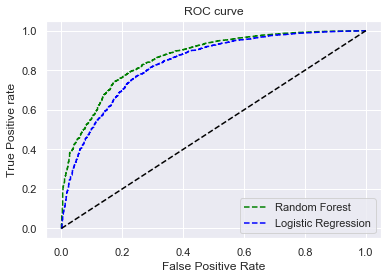

In [82]:
random_probs = [0 for i in range(len(y_test))]
r_fpr, r_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, rfc_1.predict_proba(x_test)[:,1], pos_label=1)
fpr_l, tpr_l, thresh_l = roc_curve(y_test, log_reg_1.predict_proba(x_test_scaled)[:,1], pos_label=1)

plt.plot(fpr, tpr, linestyle='--',color='green', label='Random Forest')
plt.plot(fpr_l, tpr_l, linestyle='--',color='blue', label='Logistic Regression')
plt.plot(r_fpr, r_tpr, linestyle='--',color='black')

plt.title('ROC curve')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')

plt.show()

#### Random Forest did a better classification than Logistic Regression although not by much

In [65]:
confusion_matrix(x_test, y_test, rfc_1)

(array([[   47.,   922.],
        [   27., 14975.]]),
 0.9405798008891115)

### According to the confusion matrix it can be seen that the classifier at its best classifies target '1' most of the time even when the actual value is '0'. So there are more number of False Positives than False Negatives. Although its a good practice to classify more false positives than false negatives, since false negatives might be harmful for any kind of organisation, it messes up our roc-auc curve which plots True positives rate to False positives rate. The classifier attained approximately 84% on the roc-auc score. This could be due to the imbalanced dataset or not much relevant variables which have strong correlation with the target variable.

In [66]:
X_test = test_df[['perc_premium_paid_by_cash_credit', 'application_underwriting_score', 'total_no_of_late_premium_payment', 'log_income', 'age', 'no_of_premiums_paid_bins']]
y_pred = pd.DataFrame(columns=['id', 'target'])

rfc_1.fit(X, y)

y_pred['id'] = test_df['id']
y_pred['target'] = rfc_1.predict_proba(X_test)[:, 1]

y_pred.to_csv("submission_contest.csv", index=False)
y_pred

,id,target
0,649,0.992960
1,81136,0.981812
2,70762,0.917852
3,53935,0.974505
4,15476,0.938880
...,...,...
34219,81988,0.966659
34220,30326,0.981845
34221,65749,0.961211
34222,65686,0.735500
